<h1>Executive Summary</h1>

This notebook forecast the number of views on the "Full moon" wikipedia page<br>
Data comes from wikipediatrend package in R which uses the wikipedia api

    - Data from 2017 
    - 2020 with daily freqency

Data cleaning:

    - Years before 2016 have zero views which were determined to be missing values
    - 2014 and 2015 are the worst years and where removed from analysis
        - 2014/2015 had missing values during the peak viewing times and therefore could not be ffilled
    - Missing values where filled using forward fill (ffill)
    - 2013 was then glued to 2016 in time

Modeling was performed using an LSTM in keras with:

    - 4 recurrent cells
    - trained using 10 epochs
    - mini batch size of 1
    - adam optimizer
    - mse was the value to minimize in training
    
Validation down using Time-Series CV with mean absolute percent error:

    - mape ~20% around peaks
    - mape ~13% away from peaks
    
  

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.plotting.register_matplotlib_converters()

# Plotting style
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.dpi'] = 100

# Notebook setup
%matplotlib inline

<h2>Load Data</h2>

In [2]:
CWD = os.getcwd()
FULLMOON_DATA_PATH = os.path.join(CWD, 'data/moon_wiki_views.csv')

fullmoon = pd.read_csv(FULLMOON_DATA_PATH)
fullmoon.head()

,Unnamed: 0,language,article,date,views
0,1462,en,full_moon,2007-12-10,823
1,1463,en,full_moon,2007-12-11,726
2,1464,en,full_moon,2007-12-12,969
3,1465,en,full_moon,2007-12-13,821
4,1466,en,full_moon,2007-12-14,677


In [3]:
fullmoon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4406 entries, 0 to 4405
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4406 non-null   int64 
 1   language    4406 non-null   object
 2   article     4406 non-null   object
 3   date        4406 non-null   object
 4   views       4406 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 172.2+ KB


<h3>Basic Data Cleaning</h3>

In [4]:
#Convert date column to datetime
fullmoon['date'] = pd.to_datetime(fullmoon['date'])

#Remove leap year
def is_leap_and_29Feb(x):
    is_leap = False
    if (x.month == 2) & (x.day == 29):
        is_leap = True

    return is_leap

fullmoon['is_leap'] = fullmoon['date'].apply(is_leap_and_29Feb)
fullmoon = fullmoon[fullmoon['is_leap'] == False]
fullmoon.drop(['is_leap'], axis=1, inplace=True)

<h2>Exploratory Data Analysis</h2>

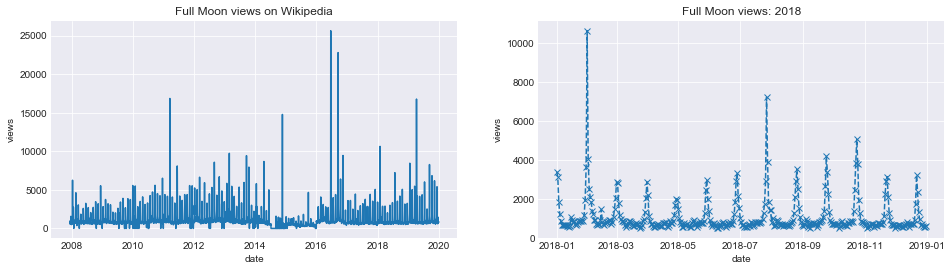

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(fullmoon['date'], fullmoon['views'])
axes[0].set_ylabel('views')
axes[0].set_xlabel('date')
axes[0].set_title('Full Moon views on Wikipedia')

axes[1].plot(fullmoon[(fullmoon['date'].dt.year >= 2018) & (fullmoon['date'].dt.year < 2019)]['date'], 
             fullmoon[(fullmoon['date'].dt.year >= 2018) & (fullmoon['date'].dt.year < 2019)]['views'], 
             'x--')
axes[1].set_ylabel('views')
axes[1].set_xlabel('date')
axes[1].set_title('Full Moon views: 2018');

<h3>Views vs. Time</h3>

Left plot shows the full data over time.  Right plot shows data for one year (2008)

Data shows:
- 12 peaks per year
- Constant number of views away from peaks

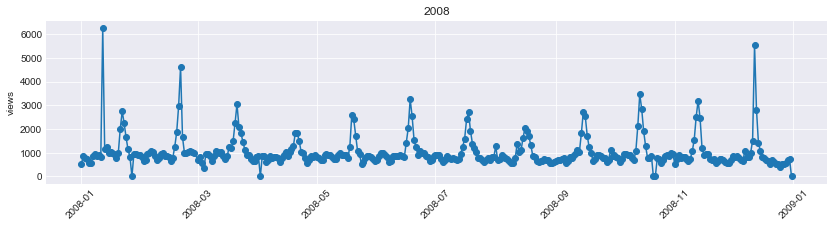

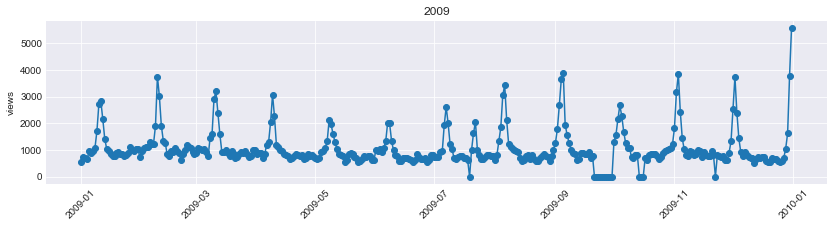

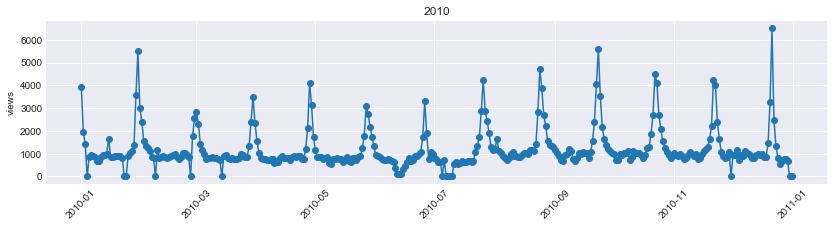

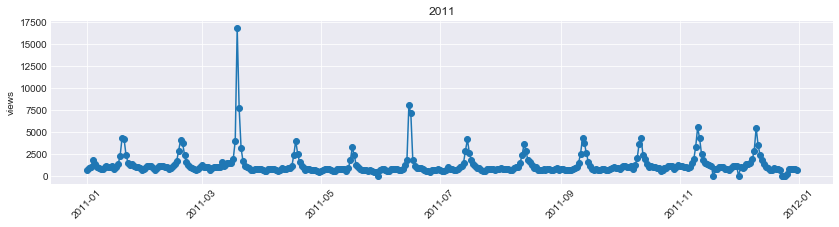

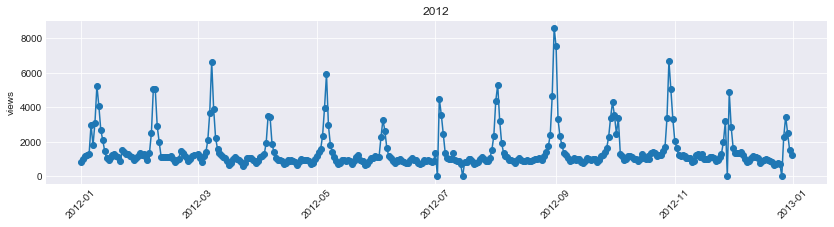

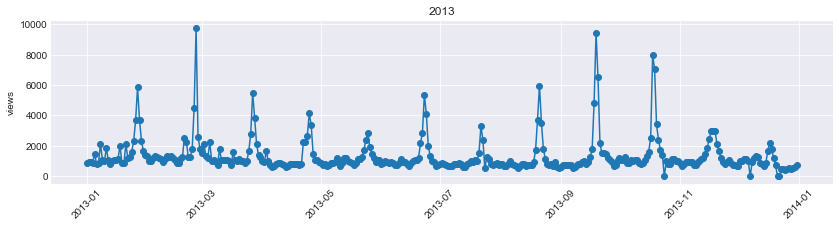

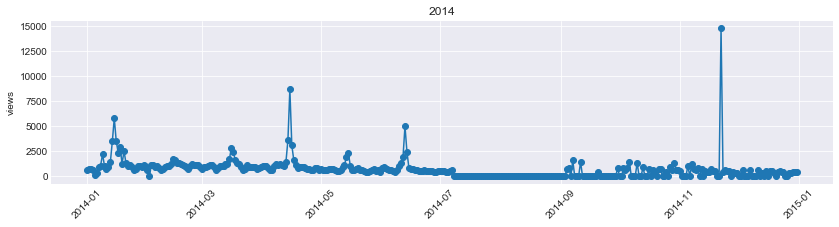

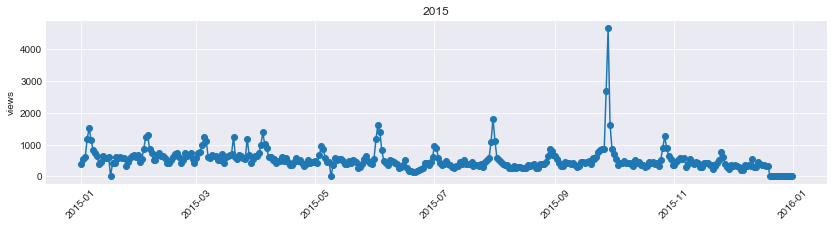

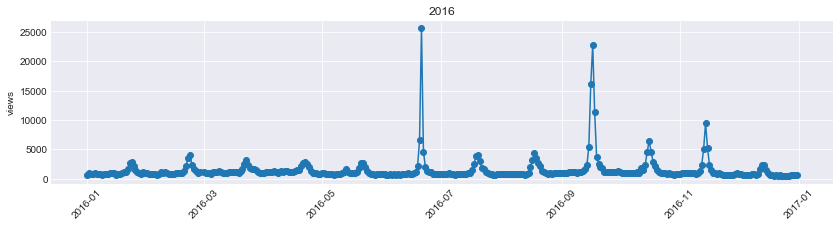

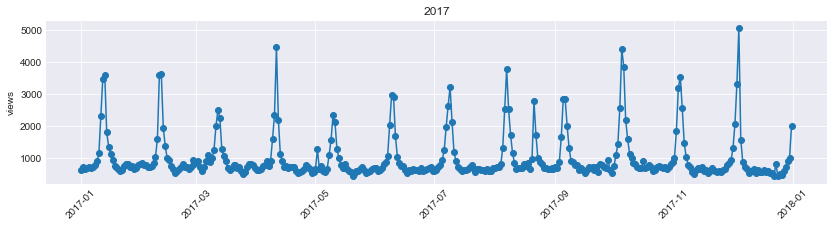

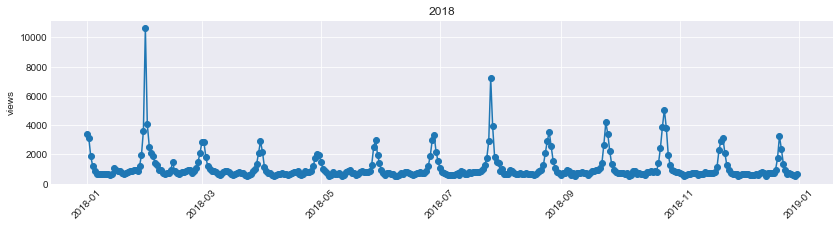

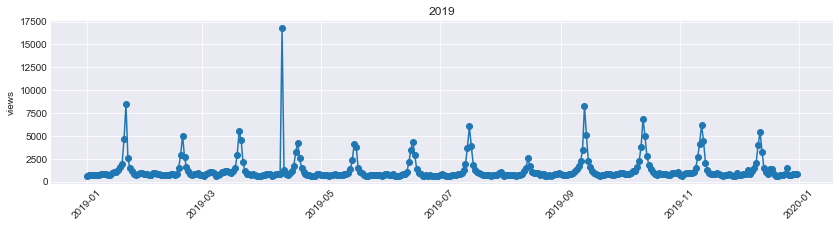

In [6]:
for add_years in range(20-8):
    plt.figure(figsize=(14, 3))
    year = 2008 + add_years
    plt.plot(fullmoon[fullmoon['date'].dt.year == year]['date'], 
             fullmoon[fullmoon['date'].dt.year == year]['views'],
            'o-')
    plt.xticks(rotation=45)
    plt.title(year)
    plt.ylabel('views');

<h3>Views by Year</h3>

- Outliers with zero number of views
    - Mostly in 2014 and 2015

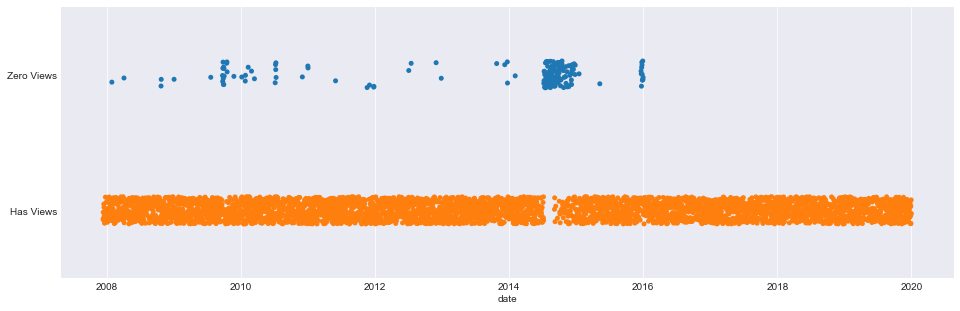

In [7]:
fullmoon['zero_view'] = fullmoon['views'].where(fullmoon['views'] == 0, 1)

fig, ax = plt.subplots(figsize=(16, 5))
sns.stripplot(x="date", y="zero_view", orient='h', data=fullmoon, ax=ax)
ax.set_yticklabels(labels=['Zero Views', 'Has Views'])
ax.set_ylabel('');

In [8]:
number_days_zero_views = 0
for idx, row in fullmoon[['date', 'views']].iterrows():
    i_date, i_views = 0, 1
    if row[i_views] == 0:
        number_days_zero_views += 1
        
print ('Number of Days with zero views: %i' % number_days_zero_views)

Number of Days with zero views: 178


<h3>Zero Views</h3>
    
- Years before 2016 have 0 view days
- 0 views are mistakes
- 2014-2015 are the worst 2 years


- Options: 
    - do not use those years
    - ignore 0 view days
    - smooth out 0 view days

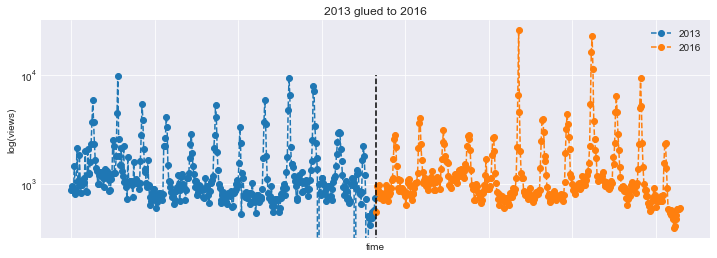

In [9]:
plt.figure(figsize=(12, 4))

plt.plot(np.arange(len(fullmoon[fullmoon['date'].dt.year == 2013])), 
         fullmoon[fullmoon['date'].dt.year == 2013]['views'], 'o--', label='2013')
plt.plot(np.arange(len(fullmoon[fullmoon['date'].dt.year == 2013]), 
                   len(fullmoon[fullmoon['date'].dt.year == 2013])
                   +len(fullmoon[fullmoon['date'].dt.year == 2016])), 
         fullmoon[fullmoon['date'].dt.year == 2016]['views'], 'o--', label='2016')
plt.plot([len(fullmoon[fullmoon['date'].dt.year == 2013]), len(fullmoon[fullmoon['date'].dt.year == 2013])], 
         [0, 10000], 'k--')
plt.ylabel('log(views)')
plt.yscale('log')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.xlabel('time')
plt.legend()
plt.title('2013 glued to 2016');

<h3>Removing 2014 & 2015</h3>

Gluing 2013 and 2016 together: There is a dip at the intersection.  Probably this will not matter too much

<h3>Data Cleaning</h3>
- Remove 2014 and 2015<br>
- Years before 2016 shift 2 years forward (i.e. 2013 -> 2015)<br>
- Forward fill 0.0 view days

In [10]:
fullmoon = fullmoon[(fullmoon['date'].dt.year != 2014) 
                    & (fullmoon['date'].dt.year != 2015)][['date', 'views']]
fullmoon['views'] = fullmoon['views'].mask(fullmoon['views']==0, np.nan)
fullmoon['views'] = fullmoon['views'].fillna(method='ffill')
fullmoon.reset_index(inplace=True)
fullmoon['index'] = fullmoon.index

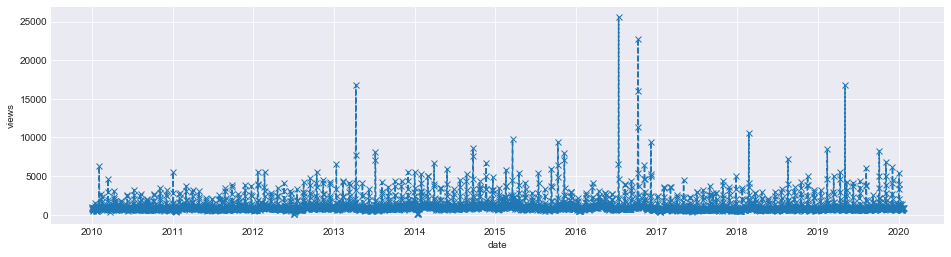

In [11]:
plt.figure(figsize=(16, 4))

fullmoon['views'].plot(marker='x', linestyle='--')
plt.xticks(np.arange(0, len(fullmoon), 365).tolist(), np.arange(2010, 2021).tolist())
plt.xlabel('date')
plt.ylabel('views');

<h3>Clean Data Views vs. Time</h3>

In [12]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5*(x-mu)*(x-mu)/(sigma*sigma))


def multiple_gaussian_peak_finder(year, df=fullmoon, to_plot=False, thres=1700):
    """Return the centers and sigmas for guassian fits within in year
    
    Function first iterates over data and finds the maximum values about thres
    """
    
    views = fullmoon[fullmoon['date'].dt.year == year]['views'].values
    indices = fullmoon[fullmoon['date'].dt.year == year]['index'].values
    starting_mu, starting_A = [], []

    in_peak = False
    current_max_count, current_max_i = 0, 0
    for i, count in zip(indices, views):
        if (count > thres):
            if count > current_max_count:
                current_max_count = count
                current_max_i = i
            in_peak = True
        elif in_peak == True:
            starting_mu.append(current_max_i)
            starting_A.append(current_max_count)
            in_peak = False
            current_max_count = 0
            current_max_i = 0
    
    if to_plot:
        plt.figure(figsize=(14, 4))
        plt.plot(fullmoon[fullmoon['date'].dt.year == year]['views']) 
        plt.ylabel('views')
        plt.xlabel('day of year index')
        plt.title('Full Moon Views: %i' % year)
        
    sigmas, mus = [], []
    for mu, A in zip(starting_mu, starting_A):
        x_indices = np.arange(mu-1.5*3, mu+1.5*3)
        popt, pcov = curve_fit(gaussian, x_indices, fullmoon.iloc[x_indices]['views'].values, p0=[A, mu, 3])
        sigmas.append(popt[2])
        mus.append(popt[1])

        y = gaussian(x_indices, popt[0], popt[1], popt[2])
        
        if to_plot:
            plt.plot(x_indices, y)
            
    print ('Average width of Gaussian fits: %0.3f\n\n' % np.mean(sigmas))
    
    return mus

Average width of Gaussian fits: 1.963




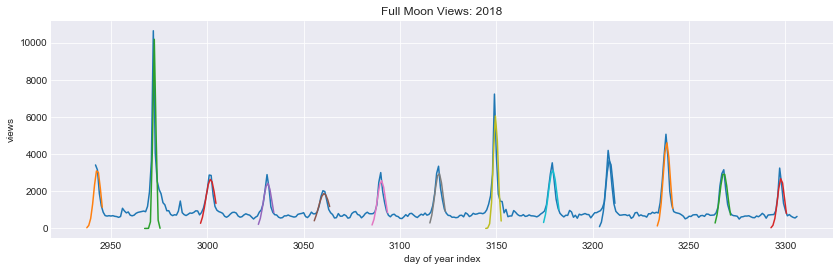

In [13]:
from scipy.optimize import curve_fit

thres = 1700
year = 2018
to_plot=True

mus = multiple_gaussian_peak_finder(year, fullmoon, to_plot, thres)

<h3>Gaussian Peak Fits</h3>

- Fitting peaks in views with a Gaussian function. 
- The average variance of these peaks is about 2 days.

<h2>Modeling</h2>

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
        
def PlotCV(x_train, y_train, y_pred, x_test, y_test, fcast, title=''):
    """Plot the CV results and forecast
    Typically used in a for loop when doing cross-validation
    """
    mape_test = 100*np.abs(y_test - fcast)/y_test
    mape_train = 100*np.abs(y_train - y_pred)/y_train
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 6))
    
    axes[0].plot(x_train, y_train, '--', label='train')
    axes[0].plot(x_train, y_pred, '--', label='predict')
    axes[0].plot(x_test, y_test, '--', label='test')
    axes[0].plot(x_test, fcast, '--', label='forecast')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylabel('views')
    axes[0].legend()
    axes[0].set_title(title)
    
    axes[1].plot(x_train, mape_train, '--', label='in-sample')
    axes[1].plot(x_test, mape_test, '--', label='forecast')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45) 
    axes[1].set_ylabel('MAPE %')
    axes[1].set_yscale('log')
    axes[1].legend()
    plt.tight_layout();

<h3>LSTM</h3>

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

def Fit_LSTM(X, Y, n_neurons, n_epoch, batch_size=1):
    """Define an RNN with:
    n_lstm_layers and n_neurons per LSTM layer
    trained with n_epoch and a mini-batch size of batch_size
    
    Args: 
        X, Y (np.array)
        n_neurons, n_epoch, batch_size (int)
    Returns:
        lstm model (keras.models.Sequential)
    """
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(n_neurons, stateful=True, batch_input_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(n_epoch):
        model.fit(X, Y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        #model.fit(X, Y, epochs=1, batch_size=batch_size, shuffle=False)
        model.reset_states()
    return model


def Error_Cal(y_train, y_test, y_forecast, error_type):
    """Return mean absolute scaled error"""
    
    error = None
    if error_type == 'mase':
        in_sample_mae = 0
        for i in range(len(y_train)-1):
            in_sample_mae += abs(y_train[i] - y_train[i+1])
        in_sample_mae /= ( len(y_train)-1 )
    
        error = (np.abs(y_test - y_forecast)).sum()
        error /= len(y_test)
    
        error = error/in_sample_mae[0]
    
    elif error_type == 'mape':
        error = ( np.abs((y_test - y_forecast)/y_test) ).sum()
        error /= len(y_test)
        
    return error


def CV_LSTM(X, Y, n_years, n_neurons, n_epoch, batch_size=1, cv_plots=True):
    """Return the Cross Validation MASE (mean absolution scaled error) error
    MASE is calculated by forcasting at most 1 year into the future
    
    Plots the CV predictions as well
    
    Args: 
        X, Y (np.array)
        n_neurons, n_epoch, batch_size (int)
        n_years (int) number of years considered: n_splits = n_years-1
    Returns:
        rmses (List(float)): rmse of each CV split
        residuals
    """
    first_year = 2010
    
    cv_errors = {'mase':[], 'mape':[], 'rmse':[]}
    cv_residuals = []
    tscv = TimeSeriesSplit(n_splits=n_years-1)
    train_year, test_year, i_count = first_year, first_year+1, 0
    for train_indices, test_indices in tscv.split(X):
        y_train, y_test = Y[train_indices], Y[test_indices]
        x_train, x_test = X[train_indices], X[test_indices]
            
        fit_lstm = Fit_LSTM(x_train, y_train, n_neurons, n_epoch, batch_size)
        y_train_pred = fit_lstm.predict(y_train.reshape(y_train.shape[0], 
                                                        1, y_train.shape[1]), batch_size=1)
        y_forecast = fit_lstm.predict(y_test.reshape(y_test.shape[0], 
                                                     1, y_test.shape[1]), batch_size=1)
        
        mase = Error_Cal(y_train, y_test, y_forecast, 'mase')
        rmse = np.sqrt(mean_squared_error(y_test, y_forecast))
        mape = Error_Cal(y_train, y_test, y_forecast, 'mape')
        residuals = y_forecast - y_test
        
        cv_errors['mase'].append(mase)
        cv_errors['rmse'].append(rmse)
        cv_errors['mape'].append(mape)
        cv_residuals.append(residuals)

        if i_count % 2 == 0:
            if cv_plots:
                i_middle = len(x_train)
                i_last = i_middle + len(x_test)
                PlotCV(np.arange(len(x_train)), y_train, y_train_pred, 
                       np.arange(i_middle, i_last), y_test, y_forecast, 
                       'train years: %i-%i,  test year: %i' % (first_year, train_year, test_year))
        
        train_year += 1
        test_year += 1
        i_count += 1
    
    return cv_errors, cv_residuals

Using TensorFlow backend.


<h4>LSTM data preparation</h4>

In [16]:
#Setup input and output data
X = fullmoon[fullmoon['date'].dt.year > 2007]['views'].values
Y = np.zeros((X.shape[0]-1, 1))
Y[:, 0] = X[1:]
X = X[:-1].reshape(-1, 1)

minmax_scaler = MinMaxScaler(feature_range=(0.001, 1))
X_scaled = minmax_scaler.fit_transform(X)
Y_scaled = minmax_scaler.transform(Y)

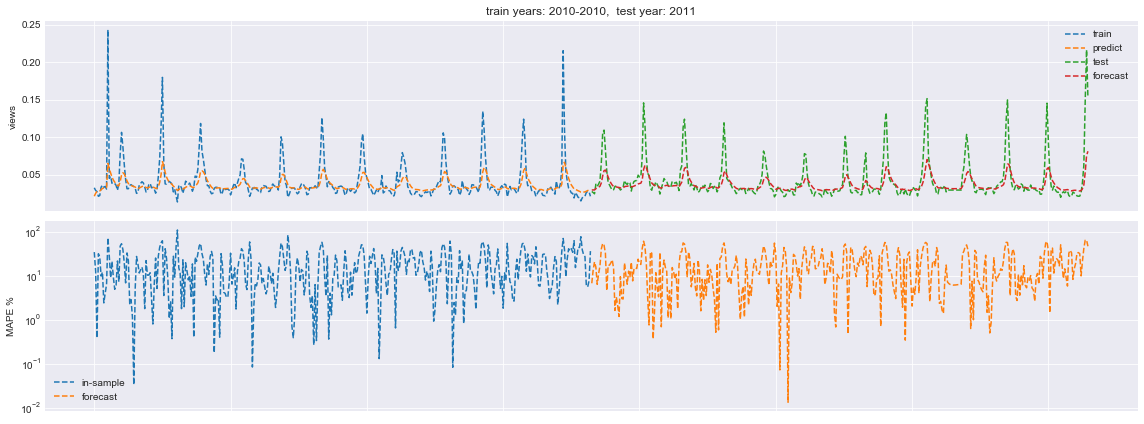

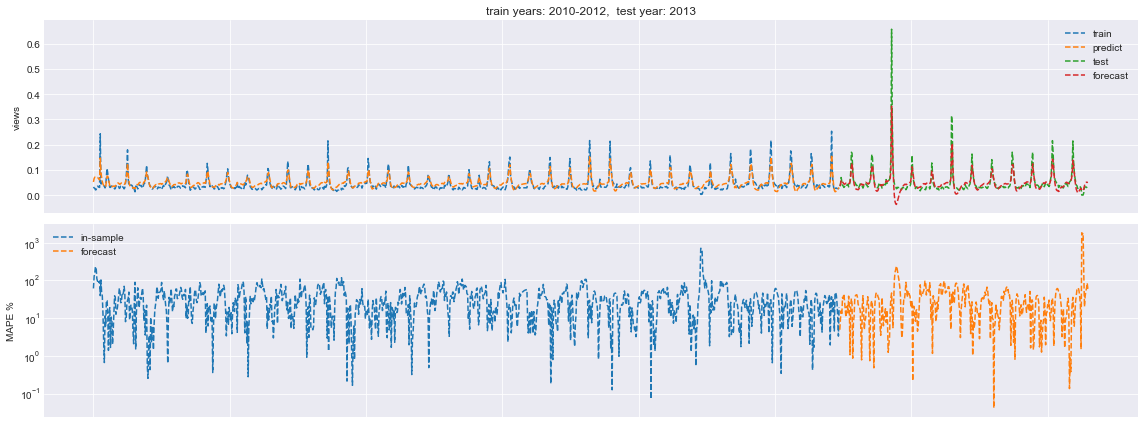

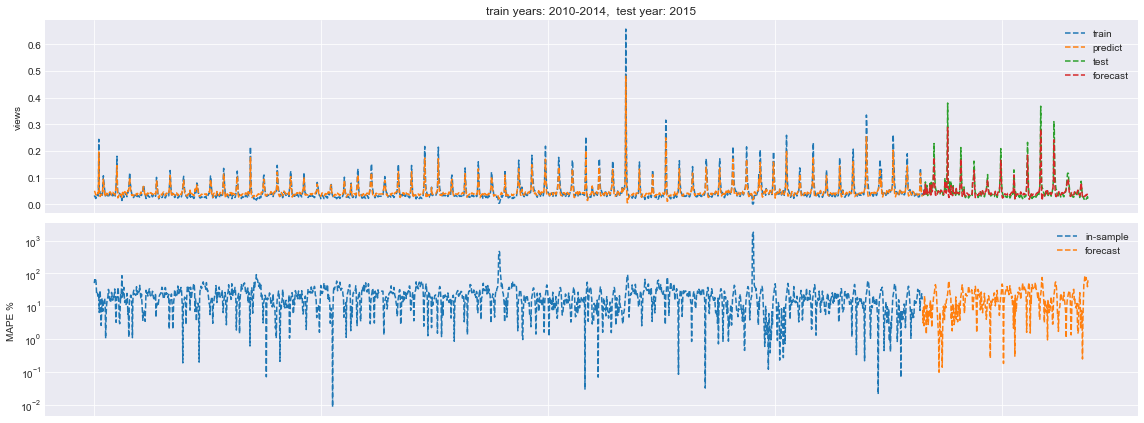

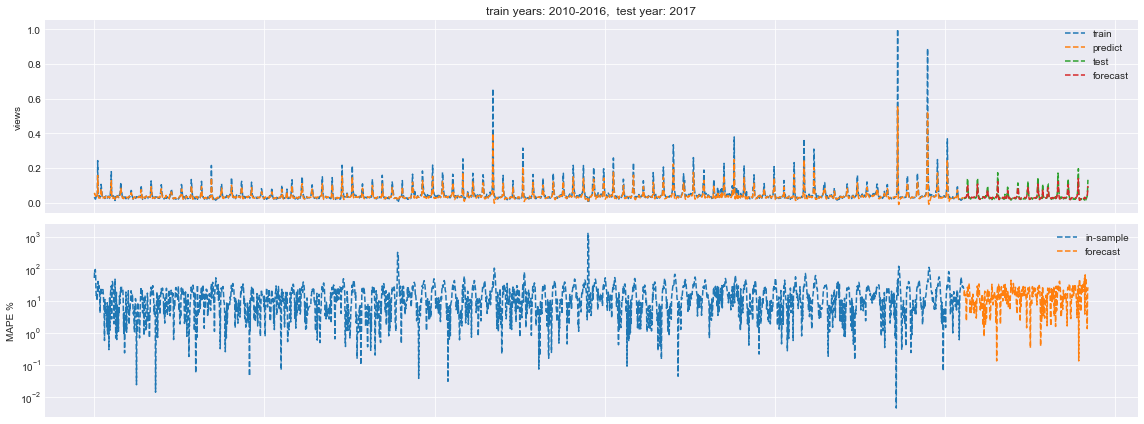

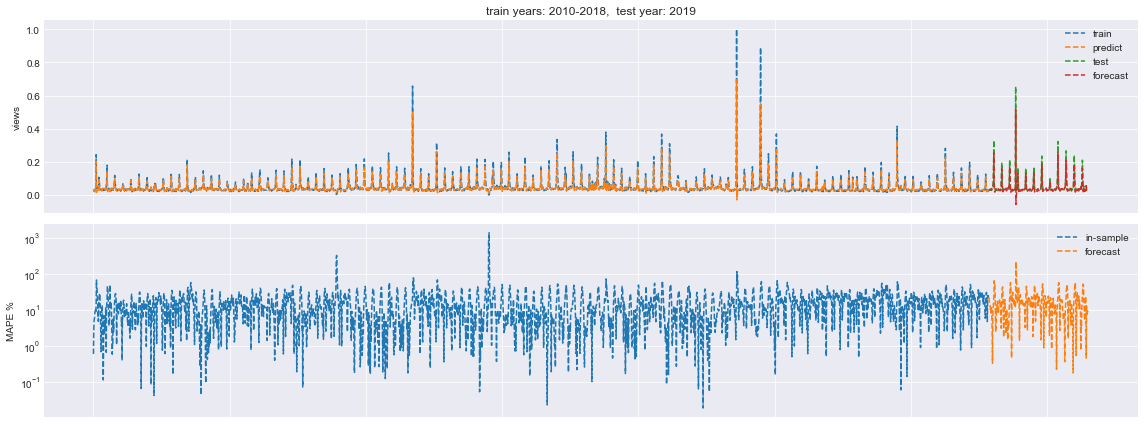

In [17]:
n_years, n_neurons, n_epoch, batch_size= 10, 4, 4, 1 #true model settings
# n_years, n_neurons, n_epoch, batch_size= 10, 4, 1, 1 #debug settings
lstm_cv_errors, lstm_cv_residuals = CV_LSTM(X_scaled, Y_scaled, n_years, n_neurons, n_epoch, batch_size)

<h3>Cross-Validation</h3>

Selected train and test splits for time series cross-validation

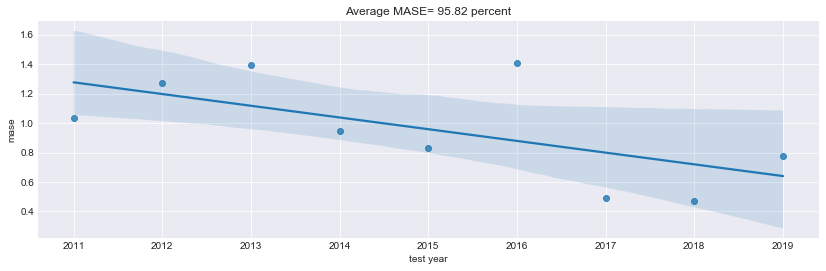

In [18]:
first_test_year = 2011

fig, axes = plt.subplots(figsize=(14, 4))

sns.regplot(np.arange(len(lstm_cv_errors['mase'])), lstm_cv_errors['mase'], ax=axes)
axes.set_xticks(np.arange(len(lstm_cv_errors['mase'])))
axes.set_xticklabels(np.arange(first_test_year, first_test_year+len(lstm_cv_errors['mase'])))
axes.set_xlabel('test year')
axes.set_ylabel('mase');
axes.set_title('Average MASE= %0.2f percent' % (100.0*np.mean(lstm_cv_errors['mase'])));

<h4>Mean Absolute Scaled Error</h4>
mase versus cross-validation test year.  Training is performed on years prior to test year and mape is calculated from the forecast values in the test year.<br>
- Obviously the negative regression slope indicates more data would improve this model<br>

<br>
The following paper describes why this metric is most useful for comparing time-series data:<br>

https://www.sciencedirect.com/science/article/abs/pii/S0169207006000239?via%3Dihub

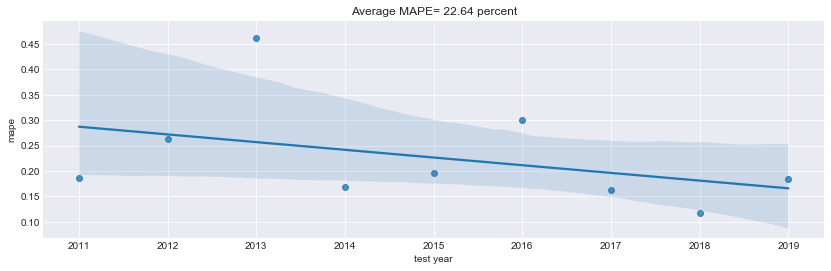

In [19]:
fig, axes = plt.subplots(figsize=(14, 4))

sns.regplot(np.arange(len(lstm_cv_errors['mape'])), lstm_cv_errors['mape'], ax=axes)
axes.set_xticks(np.arange(len(lstm_cv_errors['mape'])))
axes.set_xticklabels(np.arange(first_test_year, first_test_year+len(lstm_cv_errors['mape'])))
axes.set_xlabel('test year')
axes.set_ylabel('mape');
axes.set_title('Average MAPE= %0.2f percent' % (100.0*np.mean(lstm_cv_errors['mape'])));

<h4>Mean Absolute Percent Error</h4>
mape versus cross-validation test year.  Again training is performed on years prior to test year and mape is calculated from the forecast values in the test year.

Average width of Gaussian fits: 1.982


In peak MAPE:           22.797 pecent
Outside of peak MAPE:   15.714 pecent


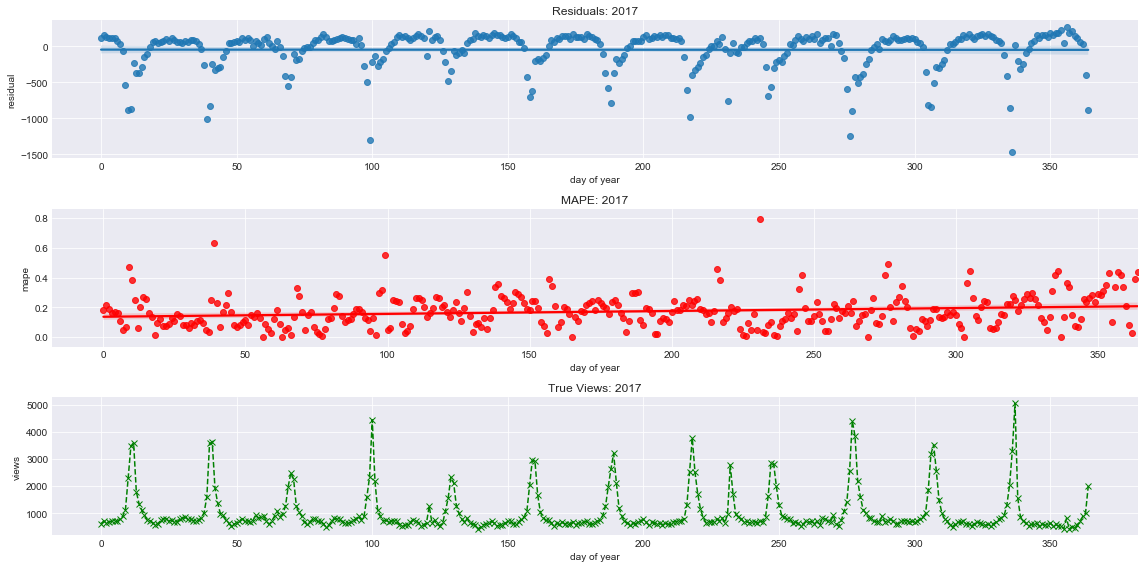

In [20]:
year = 2017

year_index = 2019-year+1
i_first, i_last = -365*year_index, -365*(year_index-1)
residuals = minmax_scaler.inverse_transform(lstm_cv_residuals[-year_index])
abs_percent_error = (np.abs(residuals)/X[i_first:i_last]).squeeze()
time_indices = fullmoon[fullmoon['date'].dt.year == year]['index'].values

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

sns.regplot(x=np.arange(len(residuals)), y=residuals, ax=axes[0])
axes[0].set_xlabel('day of year')
axes[0].set_ylabel('residual')
axes[0].set_title('Residuals: %i' % year)

sns.regplot(x=np.arange(len(residuals)), y=abs_percent_error, ax=axes[1], color='red')
axes[1].set_xlabel('day of year')
axes[1].set_ylabel('mape')
axes[1].set_title('MAPE: %i' % year)

axes[2].plot(np.arange(len(X[i_first:i_last])), X[i_first:i_last], 'x--', label='true', color='green')
axes[2].set_xlabel('day of year')
axes[2].set_ylabel('views')
axes[2].set_title('True Views: %i' % year)
plt.tight_layout()


mus = multiple_gaussian_peak_finder(year, fullmoon)
mape_in_peak, mape_off_peak = 0.0, 0.0
count_in_peak, count_off_peak = 0, 0
for i, percent_error in zip(time_indices, abs_percent_error):
    added = False
    for mu in mus:
        if (i >= mu-2*1.5) and (i <= mu+2*1.5) and (added==False):
            mape_in_peak += percent_error
            count_in_peak += 1
            added = True
    if added == False:
        mape_off_peak += percent_error
        count_off_peak += 1
        
mape_in_peak = mape_in_peak/(count_in_peak)
mape_off_peak = mape_off_peak/(count_off_peak)

print('In peak MAPE:           %0.3f pecent' % (100*mape_in_peak))
print('Outside of peak MAPE:   %0.3f pecent' % (100*mape_off_peak))

<h3>On Peak vs. Outside of Peak errors</h3>

- The average MAPE error is higher around peaks at 18.1% vs. away from peaks at 13.9%
    - Peak centers are determined from a guaussian fit
    - Peak widths were determined to be ~2 days
    - Peaks are defined as 1.5 sigma from centers